# Is Income to loan ratio a major factor in high Delinquency market?
We will answer this question by using a machine learning algorith to predict if there is a connection between income to loan ratio

In [1]:
#first we will import our inline matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import psycopg2

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
import time

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages

# We are now going to connect our postgress DB into out jupyter notebook using SQLalchemy

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
from config import POSTGRES_ADDRESS
from config import POSTGRES_PORT
from config import POSTGRES_USERNAME
from config import POSTGRES_PASSWORD
from config import POSTGRES_DBNAME

### Lets Crete our engine to link postgress to our jupyter file. This will allow us to access the dataset we have uploaded.

In [5]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname=POSTGRES_DBNAME))
# Create the connection
engine = create_engine(postgres_str)

In [6]:
merged_db= pd.read_sql_query('''SELECT * FROM merged;''', engine)
merged_db

,loan_identifier,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,...,monthly_reporting_period,current_interest_rate,loan_age,remaining_months_to_legal_maturity,adj_remaining_months_to_maturity,maturity_date,msa,current_loan_delinquency_status,modification_flag,delinquency
0,100000913397,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,...,2019-12-01,5.88,14.0,346.0,346.0,2048-10-01,40140.0,0,N,False
1,100017539727,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,...,2019-12-01,4.75,11.0,349.0,349.0,2049-01-01,26420.0,0,N,False
2,100018053040,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,...,2019-12-01,4.88,12.0,348.0,348.0,2048-12-01,0.0,0,N,False
3,100019764317,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,...,2019-10-01,4.88,9.0,351.0,0.0,2049-01-01,16980.0,X,N,True
4,100019765730,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,...,2019-12-01,4.25,8.0,352.0,352.0,2049-04-01,41860.0,0,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297447,999977469387,C,PENNYMAC CORP.,5,250000,360,2018-12-01,2019-02-01,80,80,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297448,999978067692,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",5,123000,360,2018-12-01,2019-02-01,95,95,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297449,999983023544,R,OTHER,5,280000,240,2018-12-01,2019-02-01,69,69,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297450,999984004377,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,155000,360,2019-01-01,2019-03-01,97,97,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None


### Description Of The Source Of Data

Fannie Mae provides loan performance data on a portion of its single-family mortgage loans to promote better understanding of the credit performance of Fannie Mae mortgage loans.

Link: https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html

In [7]:
# Import our input dataset
#mortgage_df = pd.read_csv('Final Project Data.csv')
mortgage_df = merged_db
mortgage_df.head()

,loan_identifier,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,...,monthly_reporting_period,current_interest_rate,loan_age,remaining_months_to_legal_maturity,adj_remaining_months_to_maturity,maturity_date,msa,current_loan_delinquency_status,modification_flag,delinquency
0,100000913397,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,...,2019-12-01,5.88,14.0,346.0,346.0,2048-10-01,40140.0,0,N,False
1,100017539727,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,...,2019-12-01,4.75,11.0,349.0,349.0,2049-01-01,26420.0,0,N,False
2,100018053040,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,...,2019-12-01,4.88,12.0,348.0,348.0,2048-12-01,0.0,0,N,False
3,100019764317,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,...,2019-10-01,4.88,9.0,351.0,0.0,2049-01-01,16980.0,X,N,True
4,100019765730,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,...,2019-12-01,4.25,8.0,352.0,352.0,2049-04-01,41860.0,0,N,False


In [8]:
len(mortgage_df.index)

297452

In [9]:
mortgage_df.isnull().sum()

loan_identifier                              0
origination_channel                          0
seller_name                                  0
original_interest_rate                       0
original_upb                                 0
original_loan_term                           0
origination_date                             0
first_payment_date                           0
original_ltv                                 0
original_cltv                                0
number_of_borrowers                          0
original_dir                                96
borrower_credit_score_at_origination       385
first_time_home_buyer_indicator              0
loan_purpose                                 0
property_type                                0
number_of_units                              0
occupancy_type                               0
property_state                               0
zip_code_short                               0
primary_mortgage_insurance_percent      185901
product_type 

### Drop Cloumns with low value to our model or high NULL values

In [10]:
# Drop the unwanted variables from the data
mortgage_input = mortgage_df.drop(columns = ['loan_identifier', 
'maturity_date',
'monthly_reporting_period',
'current_interest_rate',
'loan_age',
'remaining_months_to_legal_maturity',
'adj_remaining_months_to_maturity',
'maturity_date',
'primary_mortgage_insurance_percent',
'current_loan_delinquency_status',
'modification_flag',
'seller_name',
'property_state',
'property_type',
'zip_code_short'])
mortgage_input.head()

,origination_channel,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,first_time_home_buyer_indicator,loan_purpose,number_of_units,occupancy_type,product_type,relocation_mortgage_indicator,msa,delinquency
0,C,6,324000,360,2018-09-01,2018-11-01,80,80,2,49.0,692.0,N,C,1,P,FRM,N,40140.0,False
1,B,5,307000,360,2018-12-01,2019-02-01,90,90,1,44.0,722.0,N,P,1,P,FRM,N,26420.0,False
2,R,5,256000,360,2018-11-01,2019-01-01,90,90,2,41.0,728.0,N,P,1,S,FRM,N,0.0,False
3,C,5,248000,360,2018-12-01,2019-02-01,90,90,2,40.0,730.0,Y,P,1,P,FRM,N,16980.0,True
4,B,4,490000,360,2019-03-01,2019-05-01,67,67,1,35.0,727.0,Y,P,1,P,FRM,N,41860.0,False


In [11]:
mortgage_input.isnull().sum()

origination_channel                          0
original_interest_rate                       0
original_upb                                 0
original_loan_term                           0
origination_date                             0
first_payment_date                           0
original_ltv                                 0
original_cltv                                0
number_of_borrowers                          0
original_dir                                96
borrower_credit_score_at_origination       385
first_time_home_buyer_indicator              0
loan_purpose                                 0
number_of_units                              0
occupancy_type                               0
product_type                                 0
relocation_mortgage_indicator                0
msa                                     197004
delinquency                             197004
dtype: int64

### Remove all Nan Values

In [12]:
# Drop NA rows
mortgage_input = mortgage_input.dropna()
len(mortgage_input.index)
mortgage_input.head(10)

,origination_channel,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,first_time_home_buyer_indicator,loan_purpose,number_of_units,occupancy_type,product_type,relocation_mortgage_indicator,msa,delinquency
0,C,6,324000,360,2018-09-01,2018-11-01,80,80,2,49.0,692.0,N,C,1,P,FRM,N,40140.0,False
1,B,5,307000,360,2018-12-01,2019-02-01,90,90,1,44.0,722.0,N,P,1,P,FRM,N,26420.0,False
2,R,5,256000,360,2018-11-01,2019-01-01,90,90,2,41.0,728.0,N,P,1,S,FRM,N,0.0,False
3,C,5,248000,360,2018-12-01,2019-02-01,90,90,2,40.0,730.0,Y,P,1,P,FRM,N,16980.0,True
4,B,4,490000,360,2019-03-01,2019-05-01,67,67,1,35.0,727.0,Y,P,1,P,FRM,N,41860.0,False
5,C,5,453000,360,2018-12-01,2019-02-01,69,69,2,31.0,798.0,N,P,1,P,FRM,N,45300.0,False
6,R,5,264000,360,2018-10-01,2018-12-01,95,95,2,45.0,710.0,N,P,1,P,FRM,Y,26420.0,False
7,R,5,426000,360,2019-01-01,2019-03-01,80,80,1,47.0,765.0,N,P,1,P,FRM,N,19100.0,False
8,R,5,174000,360,2018-12-01,2019-02-01,97,97,2,37.0,747.0,Y,P,1,P,FRM,N,0.0,False
9,B,5,204000,360,2019-01-01,2019-03-01,95,95,2,42.0,717.0,Y,P,1,P,FRM,N,36260.0,False


### Now that we have cleaned our data set, lets see what input we have for our ML model

In [13]:
# Generate our categorical variable list
mortgage_cat = mortgage_input.dtypes[mortgage_input.dtypes == "object"].index.tolist()
mortgage_cat

['origination_channel',
 'origination_date',
 'first_payment_date',
 'first_time_home_buyer_indicator',
 'loan_purpose',
 'occupancy_type',
 'product_type',
 'relocation_mortgage_indicator',
 'delinquency']

### Since we are focusing on potential forclosure risk, we will be looking in to all the states, all the loan sellers, type of property and other indicators

In [14]:
# Check the number of unique values in each column
mortgage_input[mortgage_cat].nunique()

origination_channel                 3
origination_date                   26
first_payment_date                 26
first_time_home_buyer_indicator     2
loan_purpose                        3
occupancy_type                      3
product_type                        1
relocation_mortgage_indicator       2
delinquency                         2
dtype: int64

### We will now use one hot encoder to turn object/string data into interbased data to set up our ML

In [15]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(mortgage_input[mortgage_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(mortgage_cat)
encode_df.head()

,origination_channel_B,origination_channel_C,origination_channel_R,origination_date_2017-02-01,origination_date_2017-03-01,origination_date_2017-04-01,origination_date_2017-05-01,origination_date_2017-06-01,origination_date_2017-07-01,origination_date_2017-08-01,...,loan_purpose_P,loan_purpose_R,occupancy_type_I,occupancy_type_P,occupancy_type_S,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


### We will now merge the one hot encoder data to our original dataset

In [16]:
# Merge one-hot encoded features and drop the originals
mortgage_merged = mortgage_input.merge(encode_df,left_index=True, right_index=True)
mortgage_merged = mortgage_merged.drop(mortgage_cat,1)
mortgage_merged.head()

,original_interest_rate,original_upb,original_loan_term,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,number_of_units,msa,...,loan_purpose_P,loan_purpose_R,occupancy_type_I,occupancy_type_P,occupancy_type_S,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
0,6,324000,360,80,80,2,49.0,692.0,1,40140.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,5,307000,360,90,90,1,44.0,722.0,1,26420.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,5,256000,360,90,90,2,41.0,728.0,1,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
3,5,248000,360,90,90,2,40.0,730.0,1,16980.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,4,490000,360,67,67,1,35.0,727.0,1,41860.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [17]:
mortgage_merged.tail()

,original_interest_rate,original_upb,original_loan_term,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,number_of_units,msa,...,loan_purpose_P,loan_purpose_R,occupancy_type_I,occupancy_type_P,occupancy_type_S,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
100286,5,279000,360,95,95,2,28.0,791.0,1,39340.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
100287,6,170000,360,97,101,1,30.0,768.0,1,24540.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
100288,5,216000,360,40,40,2,31.0,770.0,1,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
100289,5,188000,360,95,95,1,43.0,726.0,1,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
100290,4,140000,180,70,70,2,22.0,805.0,1,17460.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [18]:
#mortgage_merged = mortgage_merged.drop(columns = ['delinquency_False'])
mortgage_merged = mortgage_merged.dropna()

In [19]:
pd.set_option('display.max_rows', None)
mortgage_merged.dtypes

original_interest_rate                    int64
original_upb                              int64
original_loan_term                        int64
original_ltv                              int64
original_cltv                             int64
number_of_borrowers                       int64
original_dir                            float64
borrower_credit_score_at_origination    float64
number_of_units                           int64
msa                                     float64
origination_channel_B                   float64
origination_channel_C                   float64
origination_channel_R                   float64
origination_date_2017-02-01             float64
origination_date_2017-03-01             float64
origination_date_2017-04-01             float64
origination_date_2017-05-01             float64
origination_date_2017-06-01             float64
origination_date_2017-07-01             float64
origination_date_2017-08-01             float64
origination_date_2017-09-01             

### Once We confirmed that all our values are int64 or float64, we will create our X and y values

In [20]:
# Split our preprocessed data into our features and target arrays, we will set our target to delinquency_True 
# and our df minus delinquency_True and delinquency_false will be our y
y = mortgage_merged["delinquency_True"].values
X = mortgage_merged.drop(["delinquency_True", "delinquency_False"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Why a switch was made to Random Forest Classifier
In the second deliverable Linear regression was being used, how ever this deliverable a choice was made to switch to random forest.

After running our model through Pycaret, a toolkit which measures upwards of 15 different machine learning models and determine which will best fit our data type. Random Forest yielded best results. It makes sense since the model is sequential in nature.

In [22]:
#% For deep forest neural network use this cell and all cells with % sign
from sklearn.metrics import accuracy_score

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.780


## We have added multiple layers to better train our model with varying node sizes.
### for testing the code epoch is set to <10
### for performance and evaluation, change epoch to >70

In [23]:
#% For deep forest neural network use this cell and all cells with % sign

# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh")
)

#add multiple hidden layers
#first i created a list of int to be used as nodes, add more digits to be used as i in our range value in the next line
units = [ 25, 17, 16, 22, 35, 15, 15, 12, 8, 5]

#then using a for loop i created multiple layers for our machine learning model
for i in range( 10 ):
    nn.add( tf.keras.layers.Dense( units[i] , activation= "sigmoid" ) )

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/cp.{acc:.4f}-{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    verbose=1,
    #save_best_only=True,
    save_weights_only=False,
    save_freq='epoch')

# Train the model (play around with the epoch number, curve starts to flatten after 70-80 epochs)
fit_model = nn.fit(X_train_scaled, y_train, epochs=70, callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/70
74560/74838 [============================>.] - ETA: 0s - loss: 0.5284 - acc: 0.7800
Epoch 00001: saving model to checkpoints/cp.0.7800-01.hdf5
74838/74838 [==============================] - 7s 94us/sample - loss: 0.5283 - acc: 0.7800
Epoch 2/70
74464/74838 [============================>.] - ETA: 0s - loss: 0.5202 - acc: 0.7854
Epoch 00002: saving model to checkpoints/cp.0.7851-02.hdf5
74838/74838 [==============================] - 6s 84us/sample - loss: 0.5205 - acc: 0.7851
Epoch 3/70
74816/74838 [============================>.] - ETA: 0s - loss: 0.5205 - acc: 0.7852
Epoch 00003: saving model to checkpoints/cp.0.7851-03.hdf5
74838/74838 [==============================] - 6s 86us/sample - loss: 0.5205 - acc: 0.7851
Epoch 4/70
74272/74838 [============================>

74838/74838 [==============================] - 6s 84us/sample - loss: 0.5205 - acc: 0.7851
Epoch 32/70
74240/74838 [============================>.] - ETA: 0s - loss: 0.5204 - acc: 0.7851
Epoch 00032: saving model to checkpoints/cp.0.7851-32.hdf5
74838/74838 [==============================] - 6s 81us/sample - loss: 0.5204 - acc: 0.7851
Epoch 33/70
74176/74838 [============================>.] - ETA: 0s - loss: 0.5206 - acc: 0.7850
Epoch 00033: saving model to checkpoints/cp.0.7851-33.hdf5
74838/74838 [==============================] - 6s 80us/sample - loss: 0.5204 - acc: 0.7851
Epoch 34/70
74496/74838 [============================>.] - ETA: 0s - loss: 0.5203 - acc: 0.7852
Epoch 00034: saving model to checkpoints/cp.0.7851-34.hdf5
74838/74838 [==============================] - 6s 82us/sample - loss: 0.5205 - acc: 0.7851
Epoch 35/70
74752/74838 [============================>.] - ETA: 0s - loss: 0.5204 - acc: 0.7851
Epoch 00035: saving model to checkpoints/cp.0.7851-35.hdf5
74838/74838 [===

Epoch 65/70
74336/74838 [============================>.] - ETA: 0s - loss: 0.5203 - acc: 0.7852
Epoch 00065: saving model to checkpoints/cp.0.7851-65.hdf5
74838/74838 [==============================] - 6s 79us/sample - loss: 0.5204 - acc: 0.7851
Epoch 66/70
74432/74838 [============================>.] - ETA: 0s - loss: 0.5200 - acc: 0.7855
Epoch 00066: saving model to checkpoints/cp.0.7851-66.hdf5
74838/74838 [==============================] - 6s 80us/sample - loss: 0.5205 - acc: 0.7851
Epoch 67/70
74208/74838 [============================>.] - ETA: 0s - loss: 0.5204 - acc: 0.7851
Epoch 00067: saving model to checkpoints/cp.0.7851-67.hdf5
74838/74838 [==============================] - 6s 82us/sample - loss: 0.5204 - acc: 0.7851
Epoch 68/70
74400/74838 [============================>.] - ETA: 0s - loss: 0.5205 - acc: 0.7851
Epoch 00068: saving model to checkpoints/cp.0.7851-68.hdf5
74838/74838 [==============================] - 6s 81us/sample - loss: 0.5204 - acc: 0.7851
Epoch 69/70
7449

## Deep Forest Result
##### We received 77% accuracy with our Model, which confirms that INCOME (MSA) has a very tight relation to Delinquency and is a major factor for mortgage loans going in a negative status.

## LETS TAKE A LOOK AT HOW OUR MODEL PERFORMED

Text(0.5, 0, 'epoch')

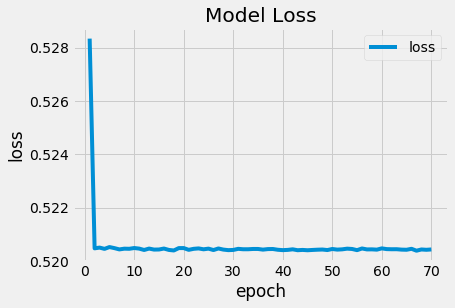

In [24]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

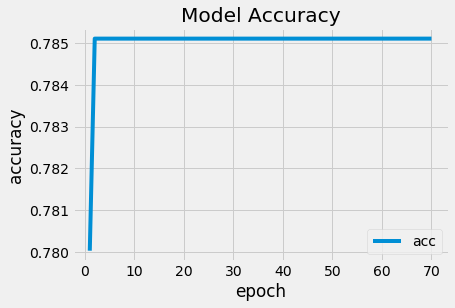

In [25]:
# Plot the accuracy
history_df.plot(y="acc")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [26]:
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.5181866624328844, Accuracy: 0.7867879867553711


In [27]:
X_train_scaled

array([[ 1.77725897,  0.58016294,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-0.09015425,  0.72986183,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-1.95756748, -1.0665249 , -2.9732483 , ...,  0.        ,
         0.07734175, -0.07734175],
       ...,
       [-0.09015425, -0.79864267,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-0.09015425,  1.95896854,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-1.95756748, -0.08166375,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175]])

In [28]:
# Save the cleaned dataframe into a csv file.
merged_db.to_csv('Mortgage_merged_db.csv', index = False)